In [1]:
import torchvision
from torchvision import datasets
from torchvision.transforms import transforms

import torch
from torch import nn
from torch.nn import functional as F
from torchmetrics import Accuracy

import numpy as np

from resnet import resnet18

from weight_drop import *

import math

## Dataset definition

In [2]:
n_labeled = 16384

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, ), (0.5, ))])
dataset_train = datasets.MNIST(root = "../data", transform = transform, train = True, download = True)
dataset_test = datasets.MNIST(root = "../data", transform = transform, train = False, download = True)

input_ch = 1
image_size = 28
dataset_name = "MNIST"

# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, ), (0.5, ))])
# dataset_train = datasets.FashionMNIST(root = "../data", transform = transform, train = True, download = True)
# dataset_test = datasets.FashionMNIST(root = "../data", transform = transform, train = False, download = True)

# input_ch = 1
# image_size = 28
# dataset_name = "FashionMNIST"

# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

# dataset_train = datasets.CIFAR10(root = "../data", transform = transform, train = True, download = True)
# dataset_test = datasets.CIFAR10(root = "../data", transform = transform, train = False, download = True)

# input_ch = 3
# image_size = 32
# dataset_name = "CIFAR10"

# transform = transforms.Compose(
#     [transforms.Grayscale(num_output_channels=1),
#      transforms.Resize((28, 28)),
#      transforms.ToTensor(),
#      transforms.Normalize((0.5,), (0.5,))])
# dataset_train = datasets.CIFAR10(root="../data", transform=transform, train=True, download=True)
# dataset_test = datasets.CIFAR10(root="../data", transform=transform, train=False, download=True)

# input_ch = 1
# image_size = 28
# dataset_name = "CIFAR10-grayscale"

dataset_train_full = dataset_train
dataset_train = torch.utils.data.Subset(dataset_train, np.random.choice(len(dataset_train), size = (n_labeled,)))
n_classes = 10

In [3]:
# Optional: Remove some classes from the training set
# if True:
if False:
    
    # Define classes to remove
    class_to_remove_1 = 3
    class_to_remove_2 = 5

    class_map_inv = [i for i in range(n_classes) if i != class_to_remove_1 and i != class_to_remove_2]
    class_map_inv.append(class_to_remove_1)
    class_map_inv.append(class_to_remove_2)

    # [0, 1, 2, 3, 4]
    # [0, 1, 3, 4, 2]
    # [0, 1, 4, 2, 3]

    class_map = [0 for i in range(n_classes)]
    for i in range(n_classes):
        class_map[class_map_inv[i]] = i

    print(class_map)

    # Create a custom dataset for the training set
    class LabelRemapDataset(torch.utils.data.Dataset):
        def __init__(self, dataset, label_map):
            self.dataset = dataset
            self.label_map = torch.LongTensor(label_map)

        def __getitem__(self, index):
            d, l = self.dataset[index]
            return d, self.label_map[l]

        def __len__(self):
            return len(self.dataset)

    filtered_indices_train = [i for i, (x, y) in enumerate(dataset_train_full) if y != class_to_remove_1 and y != class_to_remove_2]
    print(len(filtered_indices_train))
    dataset_train = torch.utils.data.Subset(dataset_train_full, filtered_indices_train)
    dataset_train = torch.utils.data.Subset(dataset_train, np.random.choice(len(dataset_train), size=(n_labeled,)))
    dataset_train = LabelRemapDataset(dataset_train, class_map)
    dataset_test = LabelRemapDataset(dataset_test, class_map)

    n_classes -= 2

In [4]:
# Optional: Add outlier dataset to the testing set
if True:
    
    n_contaminate = 1024
    
    class CombinedDataset(torch.utils.data.Dataset):
        def __init__(self, dataset_1, dataset_2):
            self.dataset_1 = dataset_1
            self.d1_len = len(self.dataset_1)
            self.dataset_2 = dataset_2
            self.d2_len = len(self.dataset_2)
        
        def __getitem__(self, index):
            if index < self.d1_len:
                d, l = self.dataset_1[index]
            else:
                d, l = self.dataset_2[index - self.d1_len]
            return d, l
        
        def __len__(self):
            return self.d1_len + self.d2_len
        
    # Mix with CIFAR-greyscale
    transform = transforms.Compose(
        [transforms.Grayscale(num_output_channels=1),
         transforms.Resize((28, 28)),
         transforms.ToTensor(),
         transforms.Normalize((0.5,), (0.5,))])
    dataset_test_contaminate = datasets.CIFAR10(root="../data", transform=transform, train=False, download=True)
    dataset_test_contaminate = torch.utils.data.Subset(dataset_test_contaminate, np.random.choice(len(dataset_test_contaminate), size = (n_contaminate,)))
    
    dataset_test = CombinedDataset(dataset_test, dataset_test_contaminate)

Files already downloaded and verified


## Major hparams

In [5]:
n_trials = 6
epochs = 25
batch_size = 1024

## Training

In [6]:
from tqdm import tqdm

train_dl = torch.utils.data.DataLoader(
    dataset_train, batch_size=batch_size, shuffle=True, num_workers=8)

test_dl = torch.utils.data.DataLoader(
    dataset_test, batch_size=batch_size, shuffle=False, num_workers=0)

# Training dynamics visualization
pivots = [2525, 6773, 1285, 4269, 9275, 528, 5255]
pivot_trial_acts = []

is_uncertain = False
def get_uncertain():
    return False
#     return is_uncertain
#     return True

class Network(nn.Module):
    
    def __init__(self, hidden_dim = 4096):
        
        super().__init__()

        self.hidden_dim = hidden_dim
        self.nfc = 0
        
        p = 0.95
        
######################################################
#         self.net = torch.nn.Sequential(
#             resnet18(
#                 num_classes = self.hidden_dim,
#                 zero_init_residual = False,
#                 conv1_type = "cifar",
#                 no_maxpool = True,
#                 width_per_group = 64,
#                 norm_layer = nn.InstanceNorm2d,
# #                 norm_layer = nn.Identity,
#                 input_ch = input_ch,
#                 get_uncertain = get_uncertain,
#                 p = p
#             ),
#             torch.nn.ReLU(),
#         )
        
# #         self.model_type = "ResNet18-noNorm"
#         self.model_type = "ResNet18-IN-2x-drop%3d" % (p * 100)
        
######################################################
        self.net = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(
                image_size * image_size * input_ch,
                self.hidden_dim),
#             torch.nn.BatchNorm1d(self.hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Dropout(),
        )
        
#         self.model_type = "Shallow-BN"
        self.model_type = "Shallow-Dropout"

######################################################
#         norm_layer = torch.nn.BatchNorm1d
#         norm_layer = torch.nn.Identity
#         self.net = torch.nn.Sequential(
#             torch.nn.Flatten(),
#             torch.nn.Linear(
#                 image_size * image_size * input_ch,
#                 self.hidden_dim),
#             norm_layer(self.hidden_dim, affine = False),
#             torch.nn.ReLU(),
#             self.WrappedLinear(self.hidden_dim, self.hidden_dim),
#             norm_layer(self.hidden_dim, affine = False),
#             torch.nn.ReLU(),
#             self.WrappedLinear(self.hidden_dim, self.hidden_dim),
#             norm_layer(self.hidden_dim, affine = False),
#             torch.nn.ReLU(),
#             self.WrappedLinear(self.hidden_dim, self.hidden_dim),
#             norm_layer(self.hidden_dim, affine = False),
#             torch.nn.ReLU(),
#         )
        
#         self.model_type = "5-layer MLP 0.95"

######################################################
# #         norm_layer = torch.nn.LayerNorm
# #         norm_layer = torch.nn.InstanceNorm2d
#         norm_layer = torch.nn.BatchNorm2d
# #         norm_layer = torch.nn.Identity
#         nd = self.hidden_dim // 16
#         self.net = torch.nn.Sequential(
#             *self.WrappedConvolutionalBlock(32, 32, 3, nd // 16, kernel = 5, stride = 2, norm = norm_layer, p = p), # 16x16
#             torch.nn.Flatten(),
#         )
        
#         self.model_type = "2-layer-CNN-IN-%f" % p

######################################################
#         norm_layer = torch.nn.LayerNorm
#         norm_layer = torch.nn.InstanceNorm2d
#         norm_layer = torch.nn.Identity
#         nd = self.hidden_dim // 16
#         self.net = torch.nn.Sequential(
#             *self.WrappedConvolutionalBlock(32, 32, 3, nd // 4, kernel = 5, norm = norm_layer, p = 1), # 32x32
#             *self.WrappedConvolutionalBlock(32, 32, nd // 4, nd // 2, kernel = 3, stride = 2, norm = norm_layer, p = p), # 16x16
#             *self.WrappedConvolutionalBlock(16, 16, nd // 2, nd // 2, kernel = 3, norm = norm_layer, p = p), # 16x16
#             *self.WrappedConvolutionalBlock(16, 16, nd // 2, nd, kernel = 3, stride = 2, norm = norm_layer, p = p), # 8x8
#             *self.WrappedConvolutionalBlock( 8,  8, nd, nd, kernel = 3, norm = norm_layer, p = p), # 8x8
#             *self.WrappedConvolutionalBlock( 8,  8, nd, nd, kernel = 3, stride = 2, norm = norm_layer, p = p), # 4x4
#             *self.WrappedConvolutionalBlock( 4,  4, nd, nd, kernel = 3, norm = norm_layer, p = p), # 4x4
#             torch.nn.Flatten(),
#         )
        
        self.model_type = "7-layer-CNN-IN-%f" % p

        self.head = torch.nn.Sequential(
            torch.nn.Linear(self.hidden_dim, n_classes)
        )
    
    def WrappedLinear(self, in_ch, out_ch, p = 0.5):
        layer = torch.nn.Linear(in_ch, out_ch)
#         self.nfc += 1
#         self.add_module("fc%d" % self.nfc, layer)
        return WeightDrop(layer, ['weight'], p, get_uncertain)

    def calc_same_pad(self, i: int, k: int, s: int, d: int) -> int:
        return max((math.ceil(i / s) - 1) * s + (k - 1) * d + 1 - i, 0)

    def WrappedConvolutionalBlock(self, h, w, in_ch, out_ch, norm = torch.nn.InstanceNorm2d,\
                                  kernel = 3, stride = 1, act = True, p = 0.5):
        
        conv = nn.Conv2d(in_ch, out_ch, kernel, stride = stride, 
                         padding = math.ceil(self.calc_same_pad(64, kernel, stride, 1) / 2))
        if p < 1:
            conv = WeightDrop(conv, ['weight'], p, get_uncertain)
        
        if norm is torch.nn.LayerNorm:
            bn = norm([out_ch, h // stride, w // stride])
        else:
            bn = norm(out_ch)
        
        if act:
            return [conv, bn, nn.ReLU(inplace = True)]
        else:
            return [conv, bn]

    def forward(self, x):
        return self.head(self.net(x))

device = torch.device('cuda:0')

apply_softmax = False

lossFn = nn.CrossEntropyLoss()
lossType = "CrossEnt"
apply_softmax = True

# lossFn = lambda output, y : F.mse_loss(output, F.one_hot(y, 10).float())
# lossType = "MSE"

accFn  = Accuracy()

trial_logits = []

for i in range(n_trials):
    
    pivot_acts = []
    print("Trial %d" % (i + 1))
    
    hidden_dim = 4096
    net = Network(hidden_dim)
    
    optim = torch.optim.AdamW(net.parameters(), weight_decay = 0.01)
    
    net = net.to(device)
    net.train()
    
#     print(net)
#     print(list(net.modules()))
    
    for ep in tqdm(range(epochs)):

        net.train()
        for batch in train_dl:
            
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            
#             print(y)
            
            output = net(x)
#             print(output.std())
            loss = lossFn(output, y)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            
        net.eval()
        acts = []
        for p in pivots:
            x, _ = test_dl.dataset[p]
            x = x.unsqueeze(0)
            x = x.to(device)

            z = net.net(x)
            out = (z.unsqueeze(1) * net.head[0].weight.unsqueeze(0)).squeeze().detach().cpu()

            acts.append(out)
        
        acts = np.stack(acts, 0)
        pivot_acts.append(acts)
    
    pivot_acts = np.stack(pivot_acts, 0)
    pivot_trial_acts.append(pivot_acts)
    
    # Obtain results
    net.eval()
    accuracy = 0
    cnt = 0
    logits = []
    for batch in test_dl:
        x, y = batch
        x = x.to(device)
        
        output = net(x)
        logits.append(output.detach().cpu())
        
        preds = torch.argmax(output, dim=1)
        accuracy += accFn(preds.detach().cpu(), y)
        
        cnt += 1
        
    logits = torch.cat(logits, dim = 0)
    
    if apply_softmax:
        logits = F.softmax(logits, dim = -1)
    
    trial_logits.append(logits)
    
    accuracy /= cnt
    print("Final accuracy: %.2f" % (accuracy * 100.0))

Trial 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.65it/s]


Final accuracy: 87.03
Trial 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.62it/s]


Final accuracy: 86.59
Trial 3


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.56it/s]


Final accuracy: 87.12
Trial 4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.57it/s]


Final accuracy: 86.91
Trial 5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.57it/s]


Final accuracy: 86.92
Trial 6


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.57it/s]


Final accuracy: 86.90


In [53]:
# Results with activations
net.eval()
is_uncertain = True

# for l in [1, 3, 5, 7]:
#     if 'weight' in net.net[l].module._parameters:
#         del net.net[l].module._parameters['weight']
# print(net.net[1].module._parameters)

activation = []
labels = []
for batch in test_dl:
    x, y = batch
    x = x.to(device)
    labels.append(y)

    z = net.net(x)
    out = (z.unsqueeze(1) * net.head[0].weight.unsqueeze(0)).squeeze().detach()
    
#     if apply_softmax:
#         out = F.softmax(out, dim = 1)
    
    out = out.cpu()
    
    activation.append(out)

activation = torch.cat(activation)
print(activation.shape)

if apply_softmax:
    log_act = activation
    log_sum_act = torch.sum(log_act, dim = (2), keepdim = True)
    normalized_logits = torch.exp(log_act - log_sum_act)
    print(log_act)
    nl_std = normalized_logits.std(2)
    nl_mean = normalized_logits.mean(2)
    num_logits = normalized_logits.shape[2]
    log_act_std = num_logits * torch.log(nl_std + nl_mean ** 2) - 2 * num_logits * torch.log(nl_mean)
    activation_std = torch.exp(log_act_std)
else:
    activation_std = activation.std(2)
print(activation_std.shape)

labels = torch.cat(labels, dim = 0)

# Training set activation
train_activation = []
for batch in train_dl:
    x, y = batch
    x = x.to(device)

    z = net.net(x)
    out = (z.unsqueeze(1) * net.head[0].weight.unsqueeze(0)).squeeze().detach()
    
#     if apply_softmax:
#         out = F.softmax(out, dim = 1)
    
    out = out.cpu()
    
    train_activation.append(out)

train_activation = torch.cat(train_activation)
print(train_activation.shape)

is_uncertain = False

torch.Size([11024, 10, 4096])
tensor([[[-0.0000e+00,  0.0000e+00, -0.0000e+00,  ...,  0.0000e+00,
          -0.0000e+00, -0.0000e+00],
         [ 0.0000e+00, -0.0000e+00, -0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-0.0000e+00, -0.0000e+00, -0.0000e+00,  ..., -0.0000e+00,
           0.0000e+00,  0.0000e+00],
         ...,
         [-0.0000e+00,  0.0000e+00, -0.0000e+00,  ...,  0.0000e+00,
          -0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          -0.0000e+00, -0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -0.0000e+00,  ..., -0.0000e+00,
          -0.0000e+00, -0.0000e+00]],

        [[-0.0000e+00,  0.0000e+00, -8.3556e-05,  ...,  0.0000e+00,
          -0.0000e+00, -0.0000e+00],
         [ 0.0000e+00, -0.0000e+00, -2.2809e-02,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-0.0000e+00, -0.0000e+00, -5.7631e-02,  ..., -0.0000e+00,
           0.0000e+00,  0.0000e+00],
         

In [38]:
print(activation_std)

tensor([[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        ...,
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0078],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]])


In [39]:
# Test for IN
if "2-layer-CNN-IN" in net.model_type:
    
    net.eval()
    hidden_IN_activation = []
    
    for batch in test_dl:
        x, y = batch
        x = x.to(device)

        z = net.net(x)
        bs = z.shape[0]
        wh = int(math.sqrt(z.shape[1] // (net.hidden_dim // 256)))
        ch = z.shape[1] // (wh ** 2)
        
        out = z.view(bs, ch, wh, wh).detach().cpu()

        hidden_IN_activation.append(out)

    hidden_IN_activation = torch.cat(hidden_IN_activation)
    print(hidden_IN_activation.shape)
    bs = hidden_IN_activation.shape[0]
    hidden_IN_activation_std_C = hidden_IN_activation.std(1)
    hidden_IN_activation_std_WH = hidden_IN_activation.view(bs, ch, -1).std(2)
    
    print("Channel-wise: %s" % repr(hidden_IN_activation_std_C.shape))
    print(hidden_IN_activation_std_C)
    
    print("Spatial-wise: %s" % repr(hidden_IN_activation_std_WH.shape))
    print(hidden_IN_activation_std_WH)

In [40]:
nza_count = (activation != 0).sum(2, keepdims = True)
nza_mean = activation.sum(2, keepdims = True) / nza_count
nza_var = (((activation - nza_mean) * (activation != 0)) ** 2).sum(2) / (nza_count.squeeze() - 1)
nza_std = torch.sqrt(nza_var)
print(nza_std.shape)
print(nza_std)

torch.Size([11024, 10])
tensor([[0.0298, 0.0231, 0.0291,  ..., 0.0236, 0.0207, 0.0238],
        [0.0362, 0.0260, 0.0352,  ..., 0.0340, 0.0259, 0.0365],
        [0.0222, 0.0175, 0.0269,  ..., 0.0209, 0.0190, 0.0208],
        ...,
        [0.0135, 0.0129, 0.0156,  ..., 0.0150, 0.0153, 0.0139],
        [0.0099, 0.0096, 0.0152,  ..., 0.0112, 0.0098, 0.0111],
        [0.0138, 0.0129, 0.0187,  ..., 0.0143, 0.0130, 0.0143]])


In [41]:
torch.save(trial_logits, "%dtrial_logits_%s(%d)_%s(%s)-%d.pkl" % (n_trials, dataset_name, n_labeled, net.model_type, lossType, net.hidden_dim))
torch.save(activation, "%dacts_logits_%s(%d)_%s(%s)-%d.pkl" % (n_trials, dataset_name, n_labeled, net.model_type, lossType, net.hidden_dim))

In [42]:
trial_logits_t = torch.stack(trial_logits, dim = 0)
trial_std = trial_logits_t.std(dim = 0)
print(trial_std.shape)

torch.Size([11024, 10])


## Visualizations

Hereafter we will create various visualizations based on previous computations of feature activations.  
Hope we can find something related to uncertainty.

### Activation statistics

First let's take a closer look to our activations.

[Text(0.5, 1.0, 'Test set activation abs mean / 0 neurons dead')]

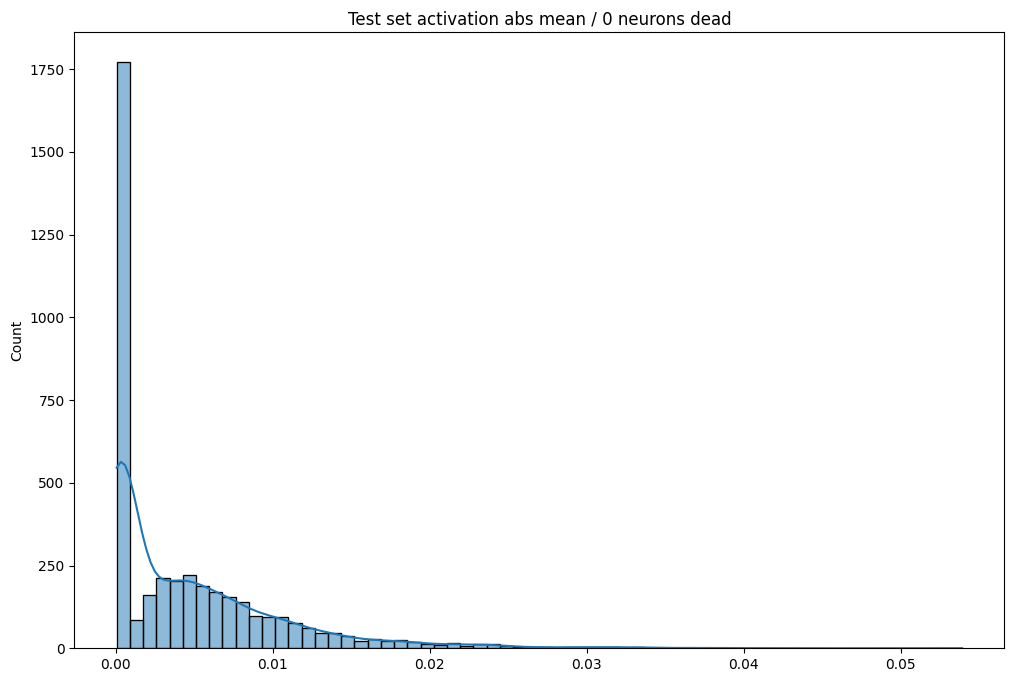

In [43]:
from matplotlib import pyplot as plt
import seaborn as sns

activation_means = torch.abs(activation).mean(axis = (0, 1))
plt.figure(figsize = (12, 8))
sns.histplot(activation_means, kde = True).set(title = "Test set activation abs mean / %d neurons dead" % (torch.sum((activation_means == 0))))

[Text(0.5, 1.0, 'Train set activation abs mean / 1546 neurons dead')]

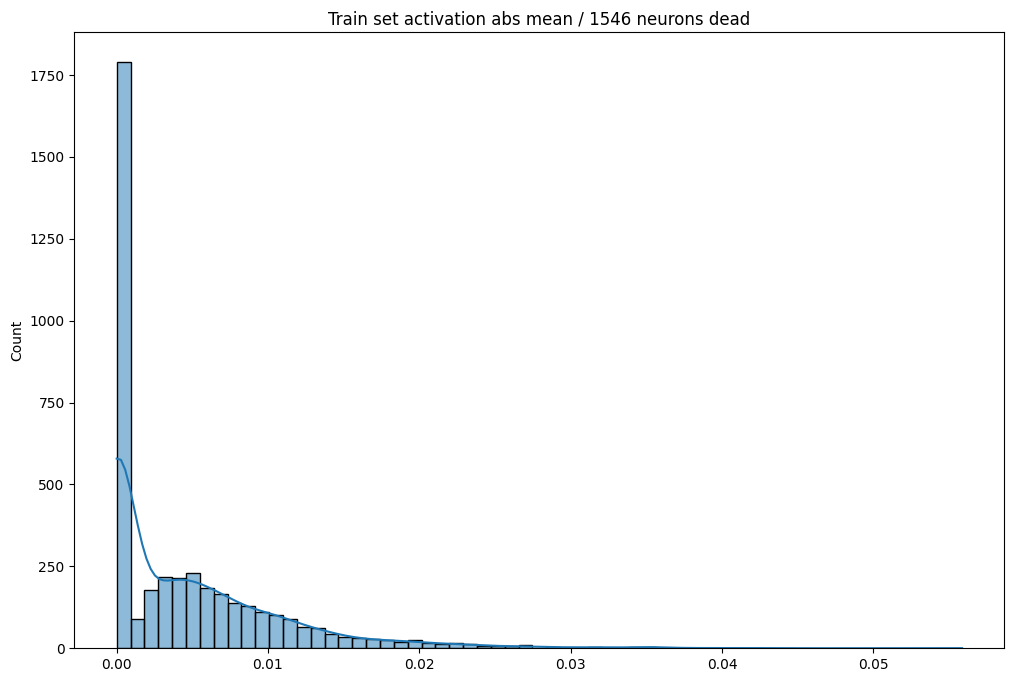

In [44]:
train_activation_means = np.abs(train_activation).mean(axis = (0, 1))
plt.figure(figsize = (12, 8))
sns.histplot(train_activation_means, kde = True).set(title = "Train set activation abs mean / %d neurons dead" % (torch.sum((train_activation_means == 0))))

### Activation estimated uncertainty vs. GT uncertainty

Next let's see how well can we estimate uncertainty from activation values of a single run.

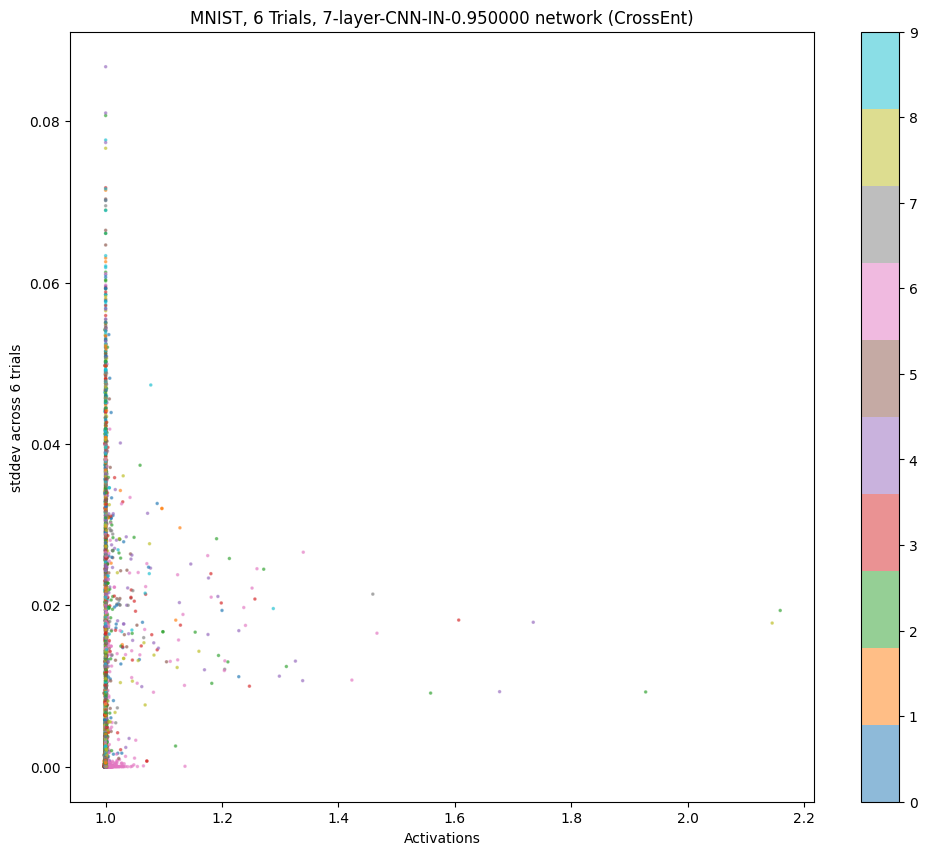

In [45]:
plt.figure(figsize = (12, 10))

colorbar = plt.scatter(
#     nza_std.mean(dim = 1), trial_std.mean(dim = 1), alpha = 0.5, marker = '.',
    activation_std.mean(dim = 1), trial_std.mean(dim = 1), alpha = 0.5, marker = '.',
    s = 10, c = labels, cmap = "tab10")
plt.colorbar(colorbar)
plt.xlabel("Activations")
plt.ylabel("stddev across %d trials" % (n_trials))
plt.title("%s, %d Trials, %s network (%s)" % (dataset_name, n_trials, net.model_type, lossType))

plt.savefig("%dtrials_%s(%d)_%s(%s)-%d.png" % (n_trials, dataset_name, n_labeled, net.model_type, lossType, net.hidden_dim))
plt.show()

In [46]:
# Test: activation skewness vs. uncertainty
activation_mean = activation.mean(2, keepdims = True)
activation_diff = activation - activation_mean

moment = 3
activation_skew = torch.mean(torch.pow(activation_diff, moment), dim = 2)
activation_skew = torch.sign(activation_skew) * torch.pow(torch.abs(activation_skew), 1 / moment)

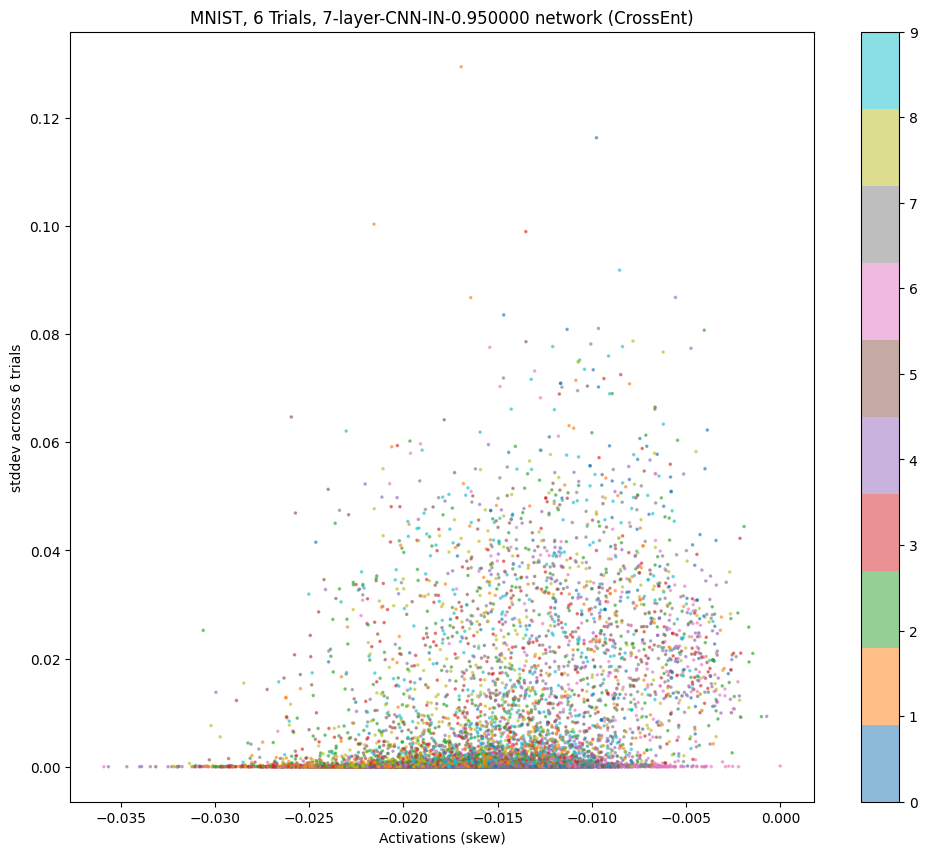

In [47]:
plt.figure(figsize = (12, 10))

colorbar = plt.scatter(
#     nza_std.mean(dim = 1), trial_std.mean(dim = 1), alpha = 0.5, marker = '.',
    activation_skew.mean(dim = 1), trial_std.mean(dim = 1), alpha = 0.5, marker = '.',
    s = 10, c = labels, cmap = "tab10")
plt.colorbar(colorbar)
plt.xlabel("Activations (skew)")
plt.ylabel("stddev across %d trials" % (n_trials))
plt.title("%s, %d Trials, %s network (%s)" % (dataset_name, n_trials, net.model_type, lossType))

plt.savefig("%dtrials_%s(%d)_%s(%s)-%d.png" % (n_trials, dataset_name, n_labeled, net.model_type, lossType, net.hidden_dim))
plt.show()

In [17]:
# Test: activation sparsity vs. uncertainty
activation_L0 = torch.sum(activation != 0, dim = 2).float() / activation.shape[2]
activation_L1 = torch.mean(torch.abs(activation), dim = 2)
print(activation_L0.shape)

torch.Size([11024, 10])


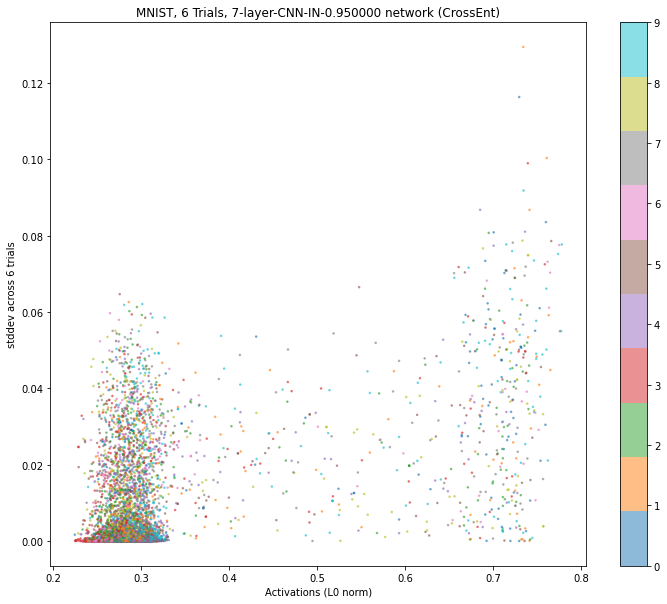

In [18]:
plt.figure(figsize = (12, 10))

colorbar = plt.scatter(
#     nza_std.mean(dim = 1), trial_std.mean(dim = 1), alpha = 0.5, marker = '.',
    activation_L0.mean(dim = 1), trial_std.mean(dim = 1), alpha = 0.5, marker = '.',
    s = 10, c = labels, cmap = "tab10")
plt.colorbar(colorbar)
plt.xlabel("Activations (L0 norm)")
plt.ylabel("stddev across %d trials" % (n_trials))
plt.title("%s, %d Trials, %s network (%s)" % (dataset_name, n_trials, net.model_type, lossType))

plt.savefig("%dtrials_%s(%d)_%s(%s)-%d.png" % (n_trials, dataset_name, n_labeled, net.model_type, lossType, net.hidden_dim))
plt.show()

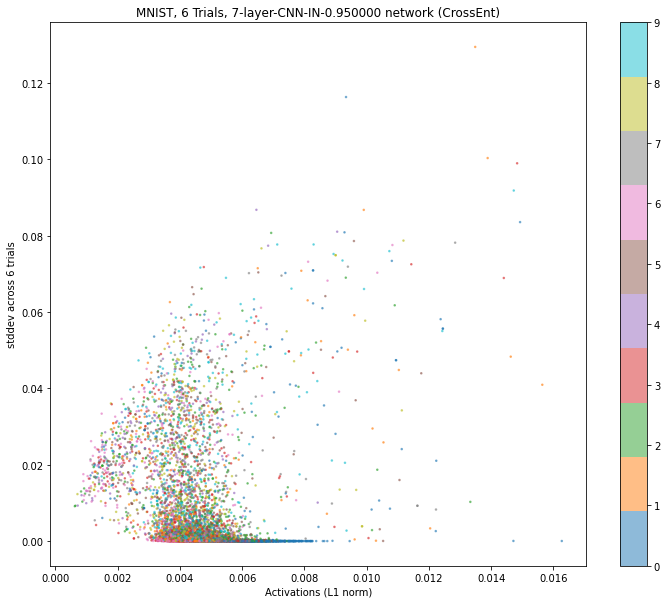

In [19]:
plt.figure(figsize = (12, 10))

colorbar = plt.scatter(
#     nza_std.mean(dim = 1), trial_std.mean(dim = 1), alpha = 0.5, marker = '.',
    activation_L1.mean(dim = 1), trial_std.mean(dim = 1), alpha = 0.5, marker = '.',
    s = 10, c = labels, cmap = "tab10")
plt.colorbar(colorbar)
plt.xlabel("Activations (L1 norm)")
plt.ylabel("stddev across %d trials" % (n_trials))
plt.title("%s, %d Trials, %s network (%s)" % (dataset_name, n_trials, net.model_type, lossType))

plt.savefig("%dtrials_%s(%d)_%s(%s)-%d.png" % (n_trials, dataset_name, n_labeled, net.model_type, lossType, net.hidden_dim))
plt.show()

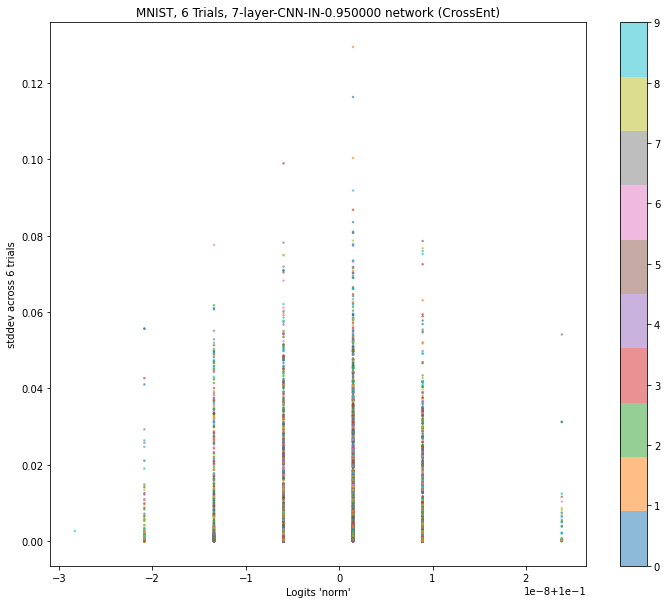

In [20]:
# Test: Network output norm vs. variance

from matplotlib import pyplot as plt
plt.figure(figsize = (12, 10))

colorbar = plt.scatter(
#     nza_std.mean(dim = 1), trial_std.mean(dim = 1), alpha = 0.5, marker = '.',
    torch.abs(logits).mean(dim = 1), trial_std.mean(dim = 1), alpha = 0.5, marker = '.',
    s = 10, c = labels, cmap = "tab10")
plt.colorbar(colorbar)
plt.xlabel("Logits 'norm'")
plt.ylabel("stddev across %d trials" % (n_trials))
plt.title("%s, %d Trials, %s network (%s)" % (dataset_name, n_trials, net.model_type, lossType))

# plt.savefig("%dtrials_%s(%d)_%s(%s)-%d.png" % (n_trials, dataset_name, n_labeled, net.model_type, lossType, net.hidden_dim))
plt.show()

ValueError: 'c' argument has 102400 elements, which is inconsistent with 'x' and 'y' with size 25600.

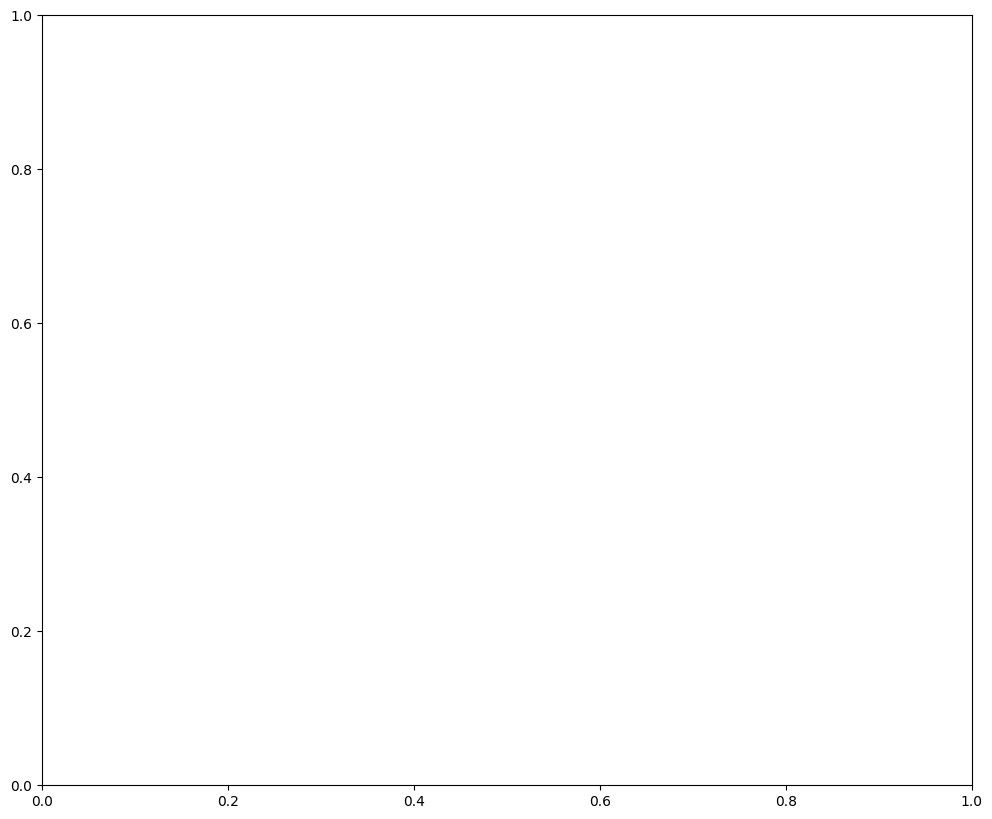

In [21]:
import seaborn as sns

from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes

sns.reset_orig()

pivot_trial_acts[0].shape
acts2D = pivot_trial_acts[0]
time = np.repeat(np.linspace(0, 1, 100)[:, None], acts2D.shape[-1], axis = -1)
idxs = np.random.choice(acts2D.shape[-1], size = (1024,), replace = False)
labl = 1
pivot_a = 1
pivot_b = 5

minlim = -0.03
maxlim =  0.03

trial_std_mean = trial_std.mean(dim = 1)

plt.figure(figsize = (12, 10))

plt.scatter(
    acts2D[:,pivot_a,labl,idxs].flatten(), acts2D[:,pivot_b,labl,idxs].flatten(), alpha = 0.1, marker = '.',
    s = 10, c = time[:,idxs])
plt.xlim(minlim, maxlim)
plt.ylim(minlim, maxlim)
plt.xlabel("# %d (%d), Var = %f" % (pivots[pivot_a], test_dl.dataset[pivots[pivot_a]][1], trial_std_mean[pivots[pivot_a]]))
plt.ylabel("# %d (%d), Var = %f" % (pivots[pivot_b], test_dl.dataset[pivots[pivot_b]][1], trial_std_mean[pivots[pivot_b]]))

# ax = plt.gca()
# sns.histplot(acts2D[-1, pivot_a, labl, :].flatten(), bins = 20, ax = ax, kde = True)

plt.scatter(0.47 / 0.50 * minlim, acts2D[-1, pivot_b, labl, :].mean(), color = 'red', marker = 'x')
plt.scatter(acts2D[-1, pivot_a, labl, :].mean(), 0.47 / 0.50 * minlim, color = 'red', marker = 'x')

plt.title("Training dynamics 2D, %s %s (%s) Label = %d" % (dataset_name, net.model_type, lossType, labl))

ax = plt.gca()
ax.patch.set_alpha(0)

fig = plt.gcf()

sns.set_theme(style="white", palette="viridis")

# Horizontal (pivot A)
#############################################################
ax = fig.add_axes([0.125, 0.125, 0.775, 0.15])
data_acts = acts2D[-1, pivot_a, labl, :].flatten()
sns.histplot(data_acts[data_acts.nonzero()], bins = 80, binrange = (0.9*minlim, 0.9*maxlim), ax = ax, kde = True)
ax.axis('off')
ax.set_xlim(minlim, maxlim)
ax.tick_params(color='red', labelcolor='red')
# ax.patch.set_alpha(0)
ax.set_zorder(-10)

# Vertical (pivot B)
#############################################################
# Rotated
ax = fig.add_axes([0.125, 0.125, 0.15, 0.755])
data_acts = acts2D[-1, pivot_b, labl, :].flatten()
sns.histplot(y = data_acts[data_acts.nonzero()], bins = 80, binrange = (0.9*minlim, 0.9*maxlim), ax = ax, kde = True)
ax.axis('off')
ax.set_ylim(minlim, maxlim)
ax.tick_params(color='green', labelcolor='green')
# ax.patch.set_alpha(0)
ax.set_zorder(-10)

ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.set_zorder(-100)

plt.savefig("NTKEnsemble/[x%d(#%d)-y%d(#%d)-at%d]%dtrials_%s(%d)_%s(%s)-%d.png" % (
    test_dl.dataset[pivots[pivot_a]][1],
    pivots[pivot_a],
    test_dl.dataset[pivots[pivot_b]][1],
    pivots[pivot_b],
    labl,
    n_trials, dataset_name, n_labeled, net.model_type, lossType, net.hidden_dim))
plt.show()